In [ ]:
from sklearn.datasets import fetch_olivetti_faces, load_iris, load_digits

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn import svm
from sklearn.tree import DecisionTreeClassifier

from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score

import logging
from time import time
from numpy.random import RandomState

# Снижение размерности: метод главных компонент и проекции на многообразия

## Задание 1. Анализ главных компонент при помощи корреляций с исходными признаками.

In [ ]:
iris = load_iris()
X = iris.data
y = iris.target
y_names = iris.target_names

Посмотрим на данные:

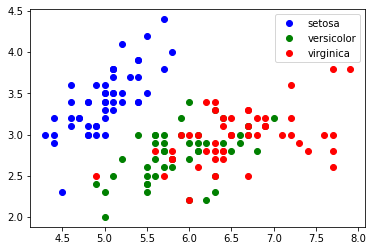

In [ ]:
plt.plot(X[y == 0, 0], X[y == 0, 1], 'bo', label=y_names[0])
plt.plot(X[y == 1, 0], X[y == 1, 1], 'go', label=y_names[1])
plt.plot(X[y == 2, 0], X[y == 2, 1], 'ro', label=y_names[2])
plt.legend(loc=0);

Как справляется с задачей SVM и Decision Trees:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, 
                                                    stratify=y, 
                                                    random_state=42)

In [ ]:
rbf = svm.SVC(probability=True, random_state=42)
rbf.fit(X_train, y_train)
flawed_pred = rbf.predict_proba(X_test)
roc_auc_score(y_test, flawed_pred, multi_class='ovr')

0.9955555555555556

In [ ]:
Cltree = DecisionTreeClassifier(max_depth=2, random_state=42)
Cltree.fit(X_train, y_train)
flawed_pred = Cltree.predict_proba(X_test)
roc_auc_score(y_test, flawed_pred, multi_class='ovr')

0.9444444444444445

Сократим размерности с помощью PCA и проверим SVM еще раз

In [ ]:
pca_scaled =  make_pipeline(StandardScaler(), PCA(n_components=2))
pca_features = pca_scaled.fit_transform(X)

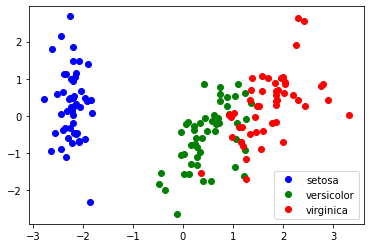

In [ ]:
plt.plot(pca_features[y == 0, 0], pca_features[y == 0, 1], 'bo', label=y_names[0])
plt.plot(pca_features[y == 1, 0], pca_features[y == 1, 1], 'go', label=y_names[1])
plt.plot(pca_features[y == 2, 0], pca_features[y == 2, 1], 'ro', label=y_names[2])
plt.legend(loc=0);

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(pca_features, y, test_size=.3, 
                                                    stratify=y, 
                                                    random_state=42)

In [ ]:
rbf = svm.SVC(probability=True, random_state=42)
rbf.fit(X_train, y_train)
pca_pred_rbf = rbf.predict_proba(X_test)

Cltree = DecisionTreeClassifier(max_depth=2, random_state=42)
Cltree.fit(X_train, y_train)
pca_pred_Cltree = Cltree.predict_proba(X_test)

#вероятность предсказывается хуже
print('SVC: ', roc_auc_score(y_test, pca_pred_rbf, multi_class='ovr'))
print('DTrees: ', roc_auc_score(y_test, pca_pred_Cltree, multi_class='ovr'))

SVC:  0.977037037037037
DTrees:  0.9277777777777777


Корреляции каждого признака с двумя компонентами

In [ ]:
f_one = pca_features[:,0]
f_two = pca_features[:,1]
X_scaled = StandardScaler().fit_transform(X)

In [ ]:
print('Корреляция каждого из признаков с первой главной компонентой:', np.corrcoef(X[:,0],f_one)[0,1], np.corrcoef(X_scaled[:,1],f_one)[0,1])
print('Корреляция каждого из признаков со второй главной компонентной: ', np.corrcoef(X[:,0],f_two)[0,1], np.corrcoef(X_scaled[:,1],f_two)[0,1])
print('Корреляция между собой компонент: ', np.corrcoef(f_one, f_two)[0,1])

Корреляция каждого из признаков с первой главной компонентой: 0.8901687648612946 -0.4601427064479085
Корреляция каждого из признаков со второй главной компонентной:  0.36082988811302513 0.8827162691623829
Корреляция между собой компонент:  -1.1601093113517825e-16


Карта вклада признаков в главные компоненты

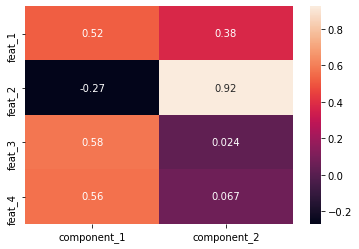

In [ ]:
#2 признак почти не присутствует в 1 компоненте, зато сильно влияет на 2 компонент (как и 4 признак)
sns.heatmap(pca_scaled.named_steps['pca'].components_.T, xticklabels=['component_1','component_2'], yticklabels=['feat_1','feat_2', 'feat_3', 'feat_4'], annot=True)
plt.show()

## Задание 2. Анализ главных компонент при помощи вкладов в их дисперсию отдельных объектов

In [ ]:
data = fetch_olivetti_faces(shuffle=True, random_state=0).data
image_shape = (64, 64)
n_samples, n_features = data.shape
faces_centered = data - data.mean(axis=0)
faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

In [ ]:
def plot_gallery(title, images, cmap=plt.cm.gray):
    plt.figure(figsize=(2. * 3, 2.26 * 2))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(2, 3, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=cmap,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

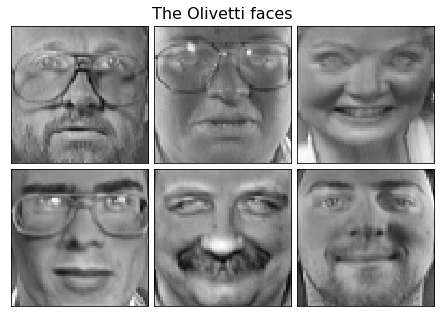

In [ ]:
plot_gallery("The Olivetti faces", faces_centered[:6])

In [ ]:
pca_scaled =  make_pipeline(StandardScaler(), PCA(whiten=True, svd_solver = 'randomized'))
pca_features = pca_scaled.fit_transform(data)

In [ ]:
pca_features

array([[ 0.07736082, -1.3287591 ,  0.8810355 , ...,  0.08268368,
         0.1450702 ,  0.9987387 ],
       [ 1.1911831 , -0.26591617, -1.9334798 , ..., -0.11727095,
         0.16576213,  0.9987495 ],
       [ 1.0898508 , -0.4023633 ,  0.19504648, ...,  0.17292395,
         0.34947026,  0.9987488 ],
       ...,
       [-0.6435259 , -0.4840046 ,  2.0196633 , ...,  0.22299367,
         0.17068793,  0.9987498 ],
       [-0.43782187,  1.0773886 ,  1.0044498 , ..., -0.18937732,
        -0.36948678,  0.9987501 ],
       [-0.9442416 ,  0.56192374, -0.09817253, ...,  0.00445304,
         0.8378193 ,  0.9987511 ]], dtype=float32)

In [ ]:
#первые 10
first_ten = pca_features[:10]
first_ten

array([[ 0.07736082, -1.3287591 ,  0.8810355 , ...,  0.08268368,
         0.1450702 ,  0.9987387 ],
       [ 1.1911831 , -0.26591617, -1.9334798 , ..., -0.11727095,
         0.16576213,  0.9987495 ],
       [ 1.0898508 , -0.4023633 ,  0.19504648, ...,  0.17292395,
         0.34947026,  0.9987488 ],
       ...,
       [-0.13989092, -1.0770075 ,  0.26566926, ...,  0.11623003,
        -0.00509538,  0.9987486 ],
       [-0.22042789,  0.22987863, -0.42097658, ..., -0.8786052 ,
         0.52012205,  0.9987488 ],
       [ 2.1409962 ,  0.18500878, -0.02824431, ..., -0.23133786,
        -0.17571194,  0.9987486 ]], dtype=float32)

In [ ]:
print('Что принозит каждый объект в дисперсию каждой из 10 компонент')
obj_input = np.zeros(first_ten.shape)

for i in range(first_ten.shape[0]):
    obj_input[i,:] = (pca_features[i,:]**2)/np.sum(pca_features[i,:]**2)

vklads = []
for j in range(first_ten.shape[0]):
    vklads.append(obj_input[j])

print(f'Вклады компонент в 1 объект {vklads[0]}')  

Что принозит каждый объект в дисперсию каждой из 10 компонент
Вклады компонент в 1 объект [1.49992338e-05 4.42506280e-03 1.94542180e-03 4.26216902e-05
 6.61481351e-07 2.14139093e-03 2.74515478e-03 5.09393914e-03
 3.08993529e-03 3.47157218e-03 2.65815668e-03 4.70913062e-03
 1.04702800e-03 6.24879170e-03 3.48343770e-03 1.25901783e-02
 9.56675154e-04 4.87146154e-03 1.18634850e-03 6.19910043e-06
 1.97818386e-04 1.85008673e-03 1.28650689e-03 4.26324783e-03
 4.83244797e-03 1.31045217e-02 3.16439709e-03 1.17513095e-03
 7.44793424e-03 9.55115902e-05 3.23568215e-03 5.00434486e-04
 1.51270675e-03 8.04452138e-05 2.44474271e-04 6.96691126e-03
 3.07384972e-03 1.01247955e-04 1.26770395e-03 1.38427285e-05
 6.26962073e-03 1.92216784e-03 2.53638905e-03 1.01905898e-03
 8.13447637e-04 2.20355834e-03 2.31287893e-04 1.10936433e-03
 3.49825058e-07 9.46146611e-04 1.05811501e-04 3.26553453e-03
 1.93058606e-03 1.11128960e-03 2.07161382e-02 1.17667927e-03
 4.04978497e-03 1.08948043e-02 3.62205785e-03 2.02212092

Непонятно, как визуализировать именно то лицо, которое вносит наибольший вклад в компоненты, поэтому не сделала 3 и 4. Да и компонент полчилось слишком много(

## Задание 3. t_SNE


Он вообще дает ссылку на гитхаб где всё написано. Но я постаралась понять)

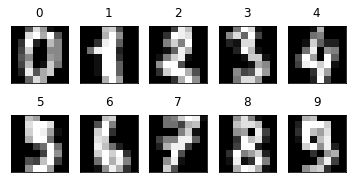

In [ ]:
digits = load_digits()
nrows, ncols = 2, 5
plt.figure(figsize=(6,3))
plt.gray()
for i in range(ncols * nrows):
    ax = plt.subplot(nrows, ncols, i + 1)
    ax.matshow(digits.images[i,...])
    plt.xticks([]); plt.yticks([])
    plt.title(digits.target[i])
plt.savefig('digits-generated.png', dpi=150)

In [ ]:
digits.target.shape

(1797,)

In [ ]:
X = np.vstack([digits.data[digits.target==i]
               for i in range(10)])
y = np.hstack([digits.target[digits.target==i]
               for i in range(10)])
digits_proj = TSNE(random_state=0).fit_transform(X)

In [ ]:
X[1]

array([ 0.,  0.,  1.,  9., 15., 11.,  0.,  0.,  0.,  0., 11., 16.,  8.,
       14.,  6.,  0.,  0.,  2., 16., 10.,  0.,  9.,  9.,  0.,  0.,  1.,
       16.,  4.,  0.,  8.,  8.,  0.,  0.,  4., 16.,  4.,  0.,  8.,  8.,
        0.,  0.,  1., 16.,  5.,  1., 11.,  3.,  0.,  0.,  0., 12., 12.,
       10., 10.,  0.,  0.,  0.,  0.,  1., 10., 13.,  3.,  0.,  0.])

In [ ]:
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txts.append(txt)

    return f, ax, sc, txts

In [ ]:
scatter(digits_proj, y)
plt.savefig('digits_tsne-generated.png', dpi=120)

## Задание 4. Анализ удовлетворенность путешественников

In [ ]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [ ]:
train['satisfaction'] = train['satisfaction'].replace({'neutral or dissatisfied': 0, 'satisfied': 1})
X = train.drop(columns='satisfaction')
y = pd.DataFrame(train['satisfaction'])

In [ ]:
def new_features(df_):
    df_ = df_.set_index(keys='id', drop=True)
    df_ = df_.sort_index()
    df = df_.copy()
    df = df.dropna()
    df['Gender'] = df['Gender'].replace({'Male': 0, 'Female': 1})
    df['Customer Type'] = df['Customer Type'].replace({'disloyal Customer': 0, 'Loyal Customer': 1})
    df['Type of Travel'] = df['Type of Travel'].replace({'Personal Travel': 0, 'Business travel': 1})
    nodum = df.drop(columns='Class')
    dum = pd.DataFrame(df['Class'])
    dummies = pd.get_dummies(dum, prefix='Class', sparse=False)
    df = pd.concat([nodum, dummies], axis = 1)
    return df

In [ ]:
newX = new_features(X)
newTest = new_features(test)

In [ ]:
newX.head()

,Unnamed: 0,Gender,Customer Type,Age,Type of Travel,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Class_Business,Class_Eco,Class_Eco Plus
id,,,,,,,,,,,,,,,,,,,,,
1,90131,0,0,48,1,821,3,3,3,3,...,2,5,4,5,5,2,5.0,1,0,0
2,47865,1,1,35,1,821,2,2,2,2,...,5,5,3,5,5,26,39.0,1,0,0
3,44425,0,1,41,1,853,4,4,4,4,...,3,3,4,3,5,0,0.0,1,0,0
4,96450,0,1,50,1,1905,2,2,2,2,...,5,5,3,5,4,0,0.0,1,0,0
5,72524,1,1,49,1,3470,3,3,3,3,...,4,3,3,3,5,0,1.0,1,0,0


In [ ]:
pca_scaled =  make_pipeline(StandardScaler(), PCA(whiten=True))
pca_features = pca_scaled.fit_transform(newX)

In [ ]:
#посчитаем в эксплейнд вэрианс в процентах
per_var = np.round(pca_scaled.named_steps['pca'].explained_variance_ratio_ * 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, 26)]

17,5% максимум у первой компоненты - в принципе можно построить 2д график из ПС1 и ПС2

<BarContainer object of 25 artists>

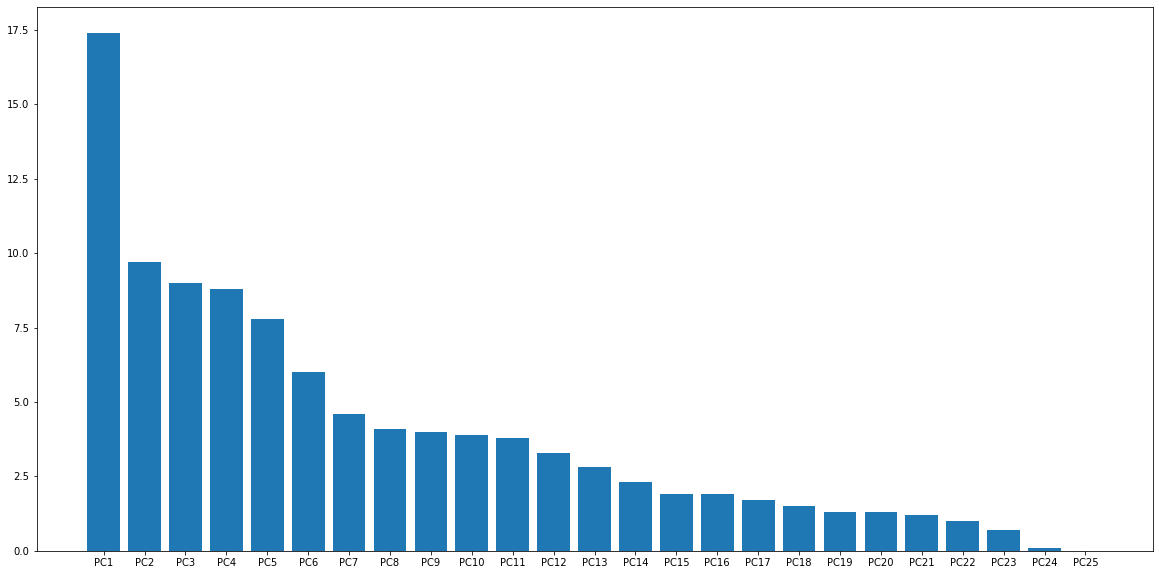

In [ ]:
f, ax = plt.subplots(figsize=(20, 10))
plt.bar(x=range(1, 26), height=per_var, tick_label=labels)

In [ ]:
newX_scaled = StandardScaler().fit_transform(newX)
print('Корреляция каждого из признаков с первой главной компонентой:', np.corrcoef(newX_scaled[:,1],pca_features[:,0])[0,1])
print('Корреляция каждого из признаков со второй главной компонентной: ', np.corrcoef(newX_scaled[:,1],pca_features[:,1])[0,1])

Корреляция каждого из признаков с первой главной компонентой: 0.014953369556463342
Корреляция каждого из признаков со второй главной компонентной:  0.002133872157498487


Не поняла как с помощью PCA показать, какие признаки влияют на удовлетворенность - мы можем показать, как выше, какие признаки больше всего контрибьютят в разные компоненты с помощью PCA, но зависимость между признаками можно и без него сделать!

Вот матрица вклада признаков в главные компоненты, например:

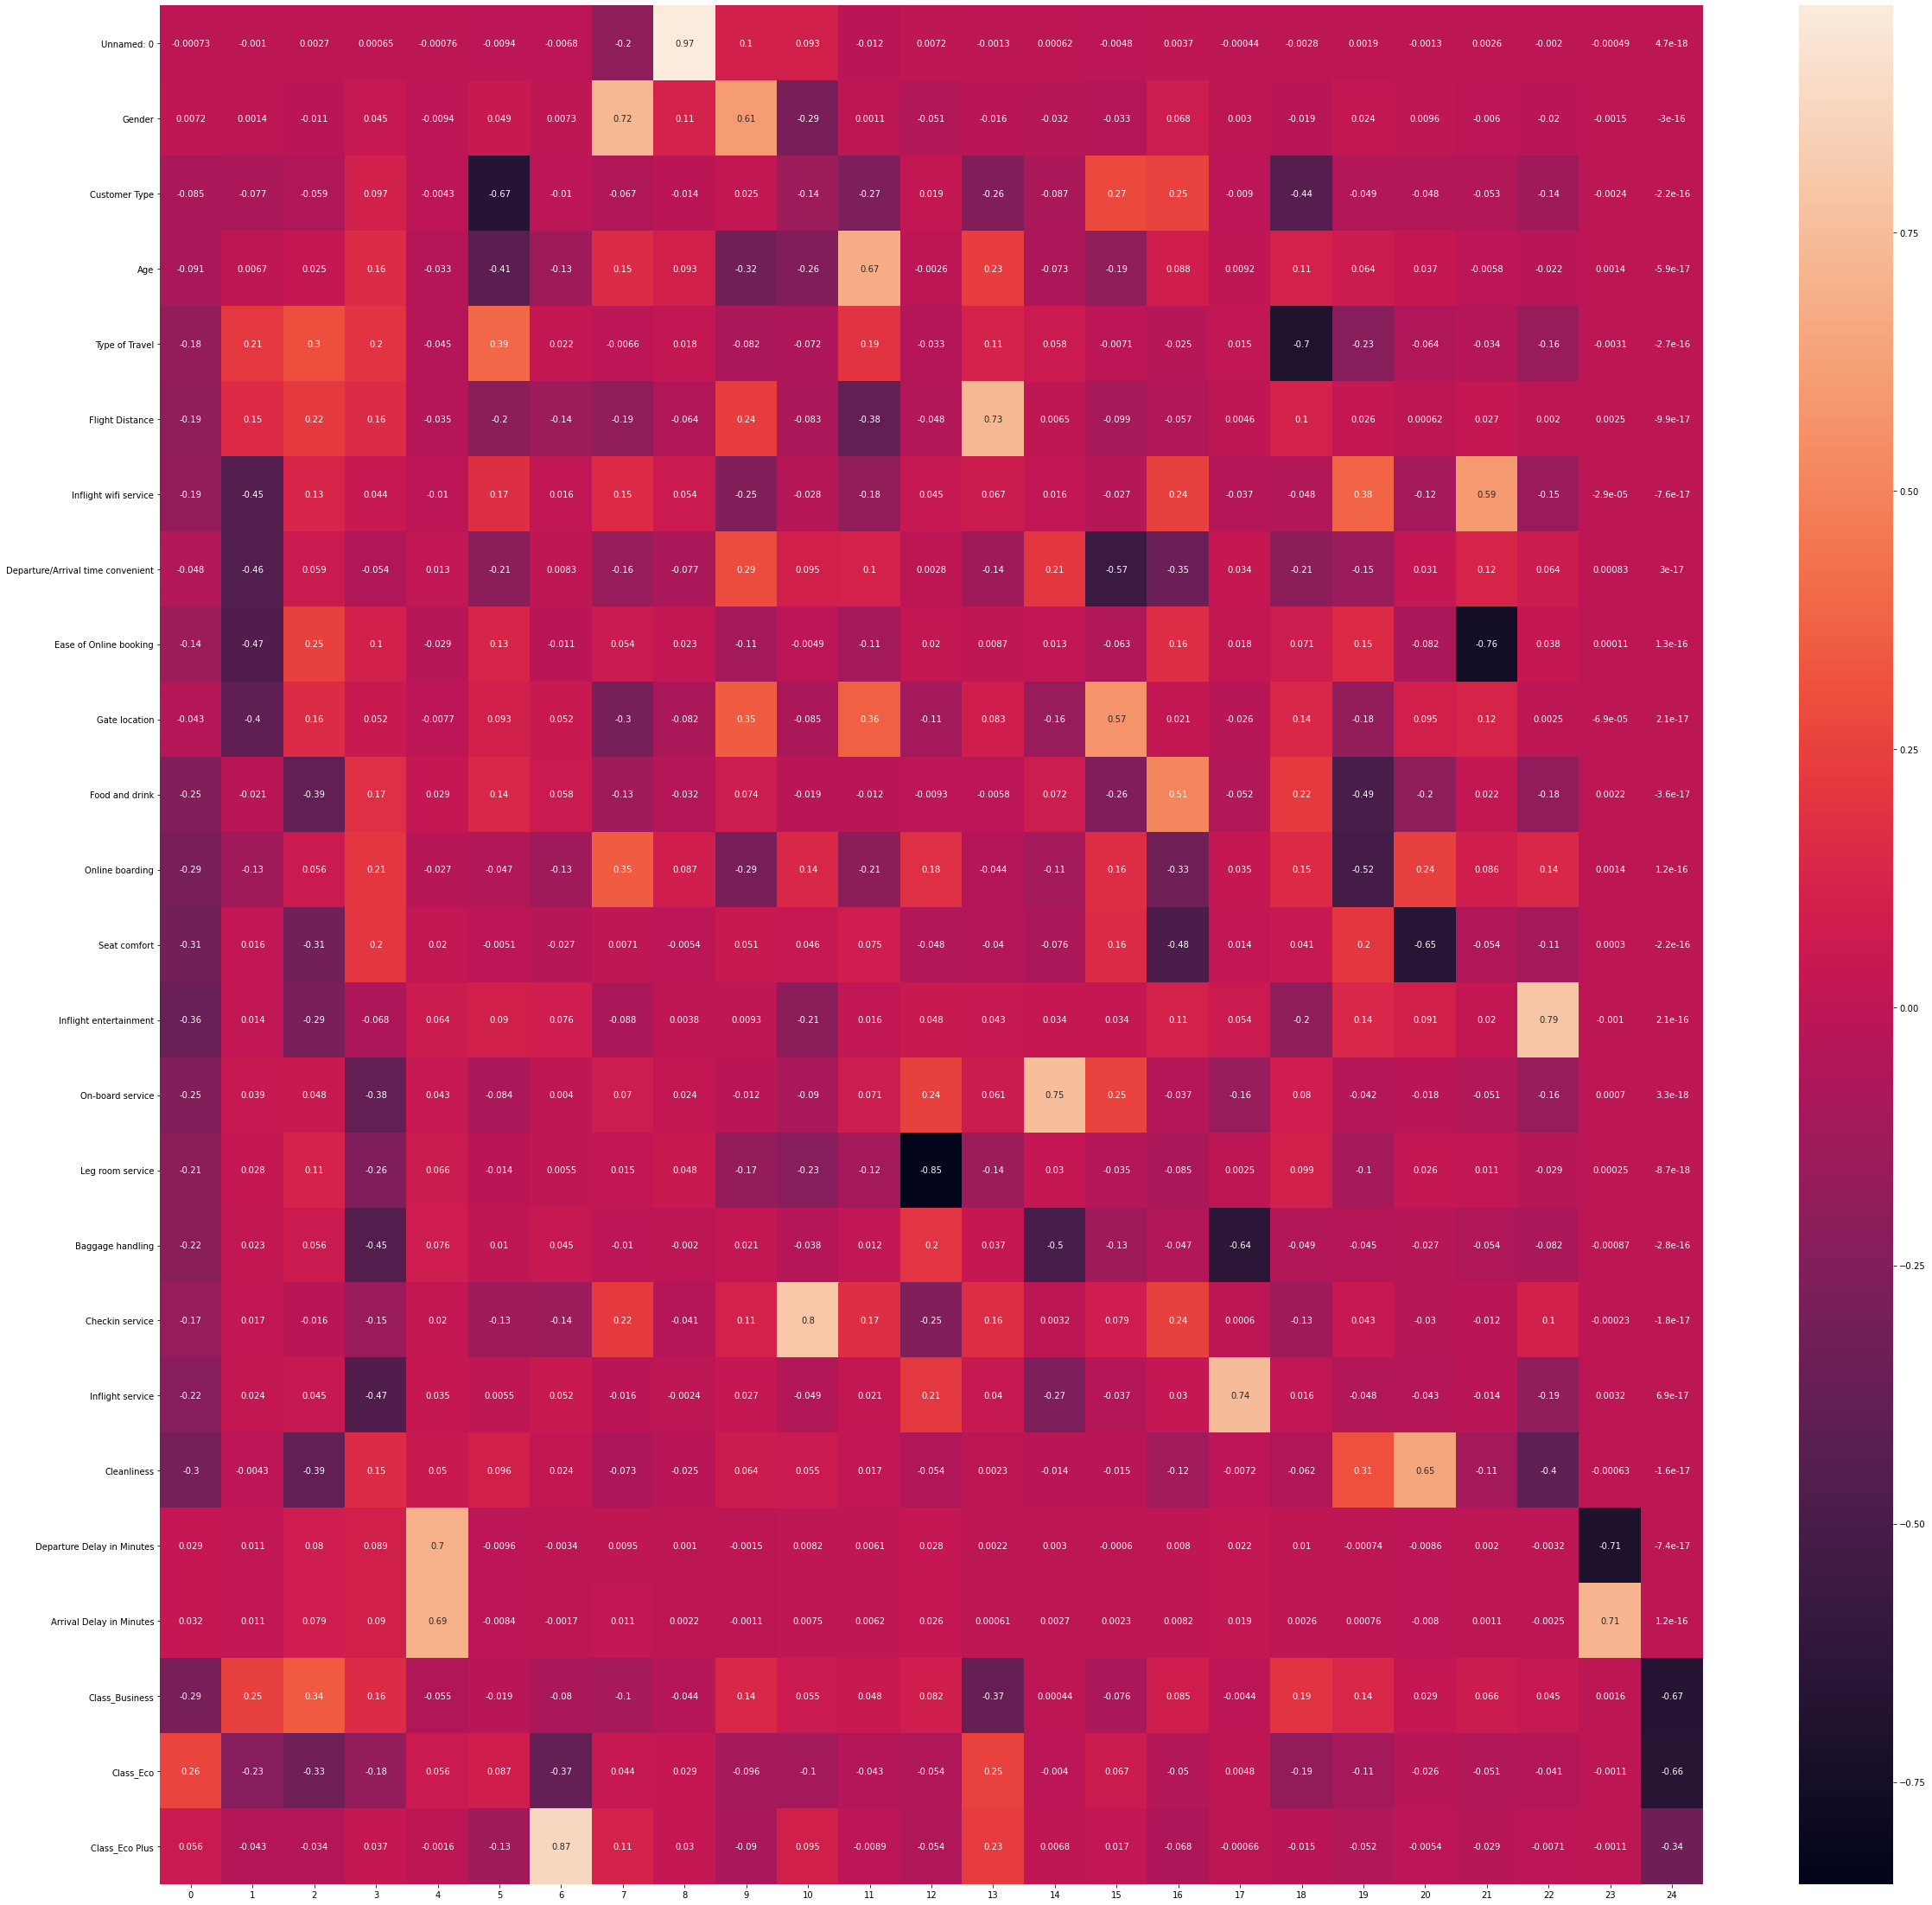

In [ ]:
f, ax = plt.subplots(figsize=(40, 40))
sns.heatmap(pca_scaled.named_steps['pca'].components_.T, 
            yticklabels=['Unnamed: 0', 'Gender', 'Customer Type', 'Age', 'Type of Travel',
           'Flight Distance', 'Inflight wifi service',
           'Departure/Arrival time convenient', 'Ease of Online booking',
           'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
           'Inflight entertainment', 'On-board service', 'Leg room service',
           'Baggage handling', 'Checkin service', 'Inflight service',
           'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes',
           'Class_Business', 'Class_Eco', 'Class_Eco Plus'], annot=True)
plt.show()